# <span style = 'color: red'>**Práctica uno.** Aprendizaje de máquina
# ***Regresión y clasificación***

## **Simón Cuartas Rendón**

En este *notebook* de Python se aborda la solución a los problemas de regresión y clasificación propuestos para la primera práctica del curso de **Aprendizaje de Máquina**.

A continuación, se abren los paquetes que se usarán tanto para los problemas de regresión como de clasificación.

**Importante.** Tanto para el problema de clasificación, como para el de regresión, se planteará un *pipeline* que permita automatizar el preprocesamiento de los datos, de tal forma que se puedan usar más adelante para cada uno de los modelos que se van a plantear.

**Importante.** Para evitar salidas demasiado extensas en el *notebook* entregable final, se obviarán las advertencias (*warnings*) de convergencia que pueden llegar a tener algunos modelos; no obstante, si esto sucede, se comenta en la sección final de cada modelo ensayado.

**Anotación**. Todo el desarrollo está disponible en línea para facilitar su revisión. Se puede acceder al repositorio de GitHub [aquí](https://github.com/scuartasr/aprendmaq_entregable_1/tree/main), y en particular, a este cuaderno [aquí](https://github.com/scuartasr/aprendmaq_entregable_1/blob/main/Cuadernos/entreg1_clasif_regres.ipynb).

In [1]:
#
# Apertura de paquetes genéricos
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Importación de matriz de confusión
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    cohen_kappa_score,
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,

    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
)

# Manejo de warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
#
# Configuración para no ver las salidas como HTML
pd.set_option('display.notebook_repr_html', False)

# <span style = 'color: green'>***1.***</span> Regresión

Para la práctica de regresión se empleará el conjunto de datos de `houseprices.csv`. Esta base contiene información del precio de venta de varias viviendas en el estado de California (Estados Unidos), e incluye un conjunto de covariables con las que se pretende poder predecir ese precio de la vivienda.

Así pues, se comenzará preprocesando la información y, a continuación, se pasará a ajustar varios modelos de regresión.

## <span style = 'color: cyan'>***1.1.***</span> Apertura del marco de datos y revisión inicial

In [3]:
#
# Apertura
direc_regr = '../Datos/houseprices.csv'
prices = pd.read_csv(direc_regr)

# Dimensión
print(f'El marco de datos tiene {prices.shape[0]} filas y {prices.shape[1]} columnas.')

El marco de datos tiene 1460 filas y 81 columnas.


In [4]:
#
# Vista de los primeros cinco registros
prices.head()

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [5]:
#
# Información de los tipos de datos
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

El listado anterior permite observar dos cosas:
- La primera es que los tipos de datos ya son los adecuados para cada variable de acuerdo con la documentación.
- Lo segundo es que existen variables que tienen poca información. Ejemplo de esto son variables como:
    - `PoolQC`, que se asocia con la calidad de la piscina, y sobre la cual solo existen siete registros.
    - `MasVnrType`, sobre el tipo de revestimiento de mampostería, que cuenta registros para una tercera parte aproximadamente de la cantidad de registros totales, en la medida que solo está disponible para 588 instancias.

En todo caso, la variable objetivo, `SalePrice`, tiene una nulidad del 0 \%.

Para continuar con el proceso de modelado, se van a conservar solo aquellas variables que tengan información disponible para al menos el 50 \% de los registros. A continuación se muestra la tasa de nulidad para cada característica:

In [6]:
#
# Tasa de nulidad por columna
tasa_nulidad = prices.isnull().sum() * 100 / len(prices)
tbl_tasa_nulidad = tasa_nulidad.apply(lambda x: f"{x:.1f}%")
print(tbl_tasa_nulidad.to_string())

Id                0.0%
MSSubClass        0.0%
MSZoning          0.0%
LotFrontage      17.7%
LotArea           0.0%
Street            0.0%
Alley            93.8%
LotShape          0.0%
LandContour       0.0%
Utilities         0.0%
LotConfig         0.0%
LandSlope         0.0%
Neighborhood      0.0%
Condition1        0.0%
Condition2        0.0%
BldgType          0.0%
HouseStyle        0.0%
OverallQual       0.0%
OverallCond       0.0%
YearBuilt         0.0%
YearRemodAdd      0.0%
RoofStyle         0.0%
RoofMatl          0.0%
Exterior1st       0.0%
Exterior2nd       0.0%
MasVnrType       59.7%
MasVnrArea        0.5%
ExterQual         0.0%
ExterCond         0.0%
Foundation        0.0%
BsmtQual          2.5%
BsmtCond          2.5%
BsmtExposure      2.6%
BsmtFinType1      2.5%
BsmtFinSF1        0.0%
BsmtFinType2      2.6%
BsmtFinSF2        0.0%
BsmtUnfSF         0.0%
TotalBsmtSF       0.0%
Heating           0.0%
HeatingQC         0.0%
CentralAir        0.0%
Electrical        0.1%
1stFlrSF   

In [7]:
#
# Alta nulidad
alta_nulidad = tasa_nulidad[tasa_nulidad > 50]
cols_alta_nulidad = alta_nulidad.index.tolist()
print(f'Columnas con nulidad superior al 50 %: {cols_alta_nulidad}')

Columnas con nulidad superior al 50 %: ['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']


In [8]:
#
# Eliminación de columnas con alta nulidad
prices.drop(columns=cols_alta_nulidad, inplace=True)

print(f'El marco de datos conserva {prices.shape[0]} filas y {prices.shape[1]} columnas.')

El marco de datos conserva 1460 filas y 76 columnas.


Respecto a las filas, dado que la mayoría de columnas tienen tasas de nulidad iguales o cercanas al 0 \%, entonces no se eliminarán registros del marco de datos. No obstante, entiendo que algunos de los modelos no aceptan trabajar con información faltante, entonces se apelará a imputadores de información automáticos del paquete de *sci-kit learn*.

In [9]:
#
# Eliminación de filas con al menos un registro nulo
prices.dropna(axis=0, how='any', inplace=True)
print(f'El marco de datos conserva {prices.shape[0]} filas y {prices.shape[1]} columnas.')

El marco de datos conserva 583 filas y 76 columnas.


In [10]:
#
# Resumen numérico
prices.describe()

                Id  MSSubClass  LotFrontage        LotArea  OverallQual  \
count   583.000000  583.000000   583.000000     583.000000   583.000000   
mean    725.248714   55.351630    75.958834   11549.427101     6.818182   
std     422.353423   36.939463    27.214024   10602.911784     1.296789   
min       2.000000   20.000000    21.000000    1300.000000     3.000000   
25%     359.000000   20.000000    60.000000    8425.000000     6.000000   
50%     703.000000   60.000000    75.000000   10261.000000     7.000000   
75%    1098.000000   60.000000    86.000000   12436.500000     8.000000   
max    1458.000000  190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count   583.000000   583.000000    583.000000   583.000000   583.000000  ...   
mean      5.511149  1978.120069   1989.219554   155.593482   526.857633  ...   
std       1.001440    29.811827     19.579247   229.145284   542.348158  ...   
min 

Se evidencia que existen variables continuas con rangos o soportes diferentes. Por ejemplo, el campo `GarageYrBlt` toma valores por el orden de los miles, toda vez que `EnclosedPorch` tomas valores que son de apenas unas cuantas decenas. En este orden de ideas, es necesario llevar a cabo un proceso de escalamiento que evite que el modelo se sesgue.

## <span style = 'color: cyan'>***1.2.***</span> Preprocesamiento de los datos

A continución, se definirá una tubería o *pipeline* con la cual se puede abordar el preprocesamiento de los datos. Para la conversión de los tipos de datos, se tomarán a las variables nominales como categóricas.

In [11]:
#
# Matriz de diseño y variable objetivo
X_regr = prices.drop(columns=['SalePrice'])
y_regr = prices['SalePrice']

In [12]:
#
# Selección de variables según su tipología
# IMPORTANTE: Solo incluir columnas que existen en X_regr
regr_num = X_regr.select_dtypes(include=['float64', 'int64']).columns.tolist()
regr_cat = X_regr.select_dtypes(include=['object', 'category']).columns.tolist()

print(
    f'Se agruparon un total de {len(regr_num)} variables numéricas y {len(regr_cat)} categóricas. \n',
    'Variables continuas:',
    regr_num,
    '\nVariables categóricas:',
    regr_cat,
    sep = '\n'
)


Se agruparon un total de 37 variables numéricas y 38 categóricas. 

Variables continuas:
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Variables categóricas:
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'K

In [13]:
#
# Imputadores
imp_num = SimpleImputer(strategy='mean')
imp_cat = SimpleImputer(strategy='most_frequent')

# Transformaciones para las variables continuas
num_pipe_regr = Pipeline(steps=[
    ('imputer', imp_num),
    ('scaler', MinMaxScaler()),
    ])

# Transformaciones para las variables categóricas
cat_pipe_regr = Pipeline(steps=[
    ('imputer', imp_cat),
    ('onehot', OneHotEncoder(
        handle_unknown='ignore',
        drop='first')),
    ])

# Preprocesamiento
preprocesador_regr = ColumnTransformer(
    transformers=[
        ('num', num_pipe_regr, regr_num),
        ('cat', cat_pipe_regr, regr_cat),
    ],
    remainder='drop'
)
preprocesador_regr

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'mean'
,fill_value,None


In [14]:
# 
# Aplicación
X_regr_preproc = preprocesador_regr.fit_transform(X_regr)

# Convertir a matriz densa
import scipy.sparse
if scipy.sparse.issparse(X_regr_preproc):
    X_regr_preproc = X_regr_preproc.toarray()

# Conversión 
X_df_regr = pd.DataFrame(X_regr_preproc, columns=preprocesador_regr.get_feature_names_out())
X_df_regr.head()

    num__Id  num__MSSubClass  num__LotFrontage  num__LotArea  \
0  0.000000         0.000000          0.202055      0.038795   
1  0.000687         0.235294          0.160959      0.046507   
2  0.001374         0.294118          0.133562      0.038561   
3  0.002060         0.235294          0.215753      0.060576   
4  0.003434         0.000000          0.184932      0.041057   

   num__OverallQual  num__OverallCond  num__YearBuilt  num__YearRemodAdd  \
0          0.428571          0.857143        0.738462           0.433333   
1          0.571429          0.428571        0.930769           0.866667   
2          0.571429          0.428571        0.269231           0.333333   
3          0.714286          0.428571        0.923077           0.833333   
4          0.714286          0.428571        0.953846           0.916667   

   num__MasVnrArea  num__BsmtFinSF1  ...  cat__SaleType_Con  \
0          0.00000         0.173281  ...                0.0   
1          0.10125         0.086

In [15]:
X_df_regr.isna().sum().sum()  # Verificar si hay valores nulos

np.int64(0)

Nótese que ya no se tienen registros nulos en el marco de datos. Además, como se puede observar, la matriz de diseño queda ahora con una mayor cantidad de columnas, gracias al aumento asociado a los diferentes niveles que pueden tener las variables categóricas. Con esto listo, basta con separar los datos en conjuntos de prueba y validación para dar paso al entrenamiento de los modelos.


In [16]:
#
# Obtención de los conjuntos de entrenamiento y prueba
X_train_regr, X_test_regr, y_train_regr, y_test_regr = train_test_split(
    X_df_regr, y_regr, test_size=0.25, random_state=42
)

## <span style = 'color: cyan'>***1.3.***</span> Regresor ***lineal sin regularización***.

En este caso se jugará con la adición o no de un intercepto para el modelo.

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
#
# Grilla de hiperparámetros
param_grid_regr_lin = {
    'fit_intercept': [True, False, ],
}

# Optimizador
grilla_regr_lin = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grid_regr_lin,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
    verbose=1,
)

# Ajuste del modelo
grilla_regr_lin.fit(X_train_regr, y_train_regr)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


,estimator,LinearRegression()
,param_grid,"{'fit_intercept': [True, False]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,fit_intercept,True


In [19]:
#
# Extracción de los resultados de la optimización
result_regr_lin = pd.DataFrame(grilla_regr_lin.cv_results_)

# Extracción de los parámetros y el MSE
result_regr_lin = result_regr_lin[['params', 'mean_test_score', 'std_test_score']]
result_regr_lin

                     params  mean_test_score  std_test_score
0   {'fit_intercept': True}    -5.077415e+09    3.291292e+09
1  {'fit_intercept': False}    -5.486366e+09    3.462834e+09

El mejor modelo es aquel que utiliza intercepto, pues tiene el MSE negativo más grande. Vale la pena notar la magnitud del error, que es bastante alto.

In [20]:
def metricas_regr(model, X_test, y_test, X_train, y_train):

    # Métricas para el conjunto de evaluación
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Métricas para el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    
    print(
        "MÉTRICAS DE EVALUACIÓN",
        '1. Conjunto de entrenamiento',
        f'MSE: {mse_train:.2f}',
        f'RMSE: {np.sqrt(mse_train):.2f}',
        f'MAE: {mae_train:.2f}',
        f'R²: {r2_train:.2f}',
        f'MAPE: {mape_train:.2%}',
        '\n'
        '2. Conjunto de prueba',
        f'MSE: {mse:.2f}',
        f'RMSE: {np.sqrt(mse):.2f}',
        f'MAE: {mae:.2f}',
        f'R²: {r2:.2f}',
        f'MAPE: {mape:.2%}',
        sep = '\n'
    )

In [21]:
metricas_regr(grilla_regr_lin.best_estimator_, X_test_regr, y_test_regr, X_train_regr, y_train_regr)

MÉTRICAS DE EVALUACIÓN
1. Conjunto de entrenamiento
MSE: 598288482.19
RMSE: 24459.94
MAE: 15755.46
R²: 0.93
MAPE: 7.51%

2. Conjunto de prueba
MSE: 5701811157.74
RMSE: 75510.34
MAE: 32618.99
R²: 0.23
MAPE: 15.84%


Como se puede observar, este modelo es bastante pobre, ya que tiene un MAE que podría considerarse bastante algo: el modelo puede equivocarse unos $32 mil dólares en promedio con la predicción del precio de la vivienda, y además, solo explica el 23 % de la variabilidad del marco de datos. Además, se tiene que en el conjunto de prueba los resultados son bastantes bueno, de manera que este modelo está memorizando los resultados y no es apto para enfrentarse a modelos descnocidos.

En definitiva, se debe apelar a un mejor modelo.

## <span style = 'color: cyan'>***1.4.***</span> Regresor ***Lasso***.

En este caso se jugará con el parámetro $\alpha$ y con la inclusión o no de un intercepto.

In [22]:
from sklearn.linear_model import Lasso

In [23]:
#
# Grilla de hiperparámetros
param_grid_lasso = {
    'fit_intercept': [True, False, ],
    'alpha': [0.1, 1, 10, 100,
              1000, 10000, 100000, 1000000, ],
}

# Optimizador
grilla_lasso = GridSearchCV(
    estimator=Lasso(),
    param_grid=param_grid_lasso,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
    verbose=1,
)

# Ajuste del modelo
grilla_lasso.fit(X_train_regr, y_train_regr)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


,estimator,Lasso()
,param_grid,"{'alpha': [0.1, 1, ...], 'fit_intercept': [True, False]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,1000


In [24]:
#
# Extracción de los resultados de la optimización
result_regr_lasso = pd.DataFrame(grilla_lasso.cv_results_)

# Extracción de los parámetros y el MSE
result_regr_lasso = result_regr_lasso[['params', 'mean_test_score', 'std_test_score']]
result_regr_lasso

                                        params  mean_test_score  \
0        {'alpha': 0.1, 'fit_intercept': True}    -4.790582e+09   
1       {'alpha': 0.1, 'fit_intercept': False}    -5.597080e+09   
2          {'alpha': 1, 'fit_intercept': True}    -4.641355e+09   
3         {'alpha': 1, 'fit_intercept': False}    -5.511840e+09   
4         {'alpha': 10, 'fit_intercept': True}    -3.990232e+09   
5        {'alpha': 10, 'fit_intercept': False}    -4.888474e+09   
6        {'alpha': 100, 'fit_intercept': True}    -3.335301e+09   
7       {'alpha': 100, 'fit_intercept': False}    -3.297792e+09   
8       {'alpha': 1000, 'fit_intercept': True}    -2.575562e+09   
9      {'alpha': 1000, 'fit_intercept': False}    -2.589335e+09   
10     {'alpha': 10000, 'fit_intercept': True}    -5.857689e+09   
11    {'alpha': 10000, 'fit_intercept': False}    -4.261734e+09   
12    {'alpha': 100000, 'fit_intercept': True}    -8.918420e+09   
13   {'alpha': 100000, 'fit_intercept': False}    -1.890929e+1

In [25]:
#
# Mejores parámetro
grilla_lasso.best_params_ 

{'alpha': 1000, 'fit_intercept': True}

El mejor modelo es aquel que utiliza intercepto y toma un $\alpha = 1000$, pues tiene el MSE negativo más grande. Vale la pena notar la magnitud del error, que es bastante alto.

In [26]:
metricas_regr(grilla_lasso.best_estimator_, X_test_regr, y_test_regr, X_train_regr, y_train_regr)

MÉTRICAS DE EVALUACIÓN
1. Conjunto de entrenamiento
MSE: 1911212320.35
RMSE: 43717.41
MAE: 26730.79
R²: 0.79
MAPE: 12.33%

2. Conjunto de prueba
MSE: 1424889335.75
RMSE: 37747.71
MAE: 25870.01
R²: 0.81
MAPE: 11.51%


Esta regresión mejora de forma significativa el resultado del modelo anterior, pues de acuerdo con el MAE, el error promedio se recorta en unos \$7 mil dólares, al marcar un registro de \$25.8 mil dólares. Adicionalmente, se tiene que la explicabilidad de la varianza aumenta de forma importante al obtener un 81 \%. Algo positivo de este modelo es que los resultados tanto para el conjunto de entrenamiento como de prueba son bastante semejantes, lo que da cuenta de la buena capacidad de generalización que tiene este modelo.

## <span style = 'color: cyan'>***1.5.***</span> Regresor ***Ridge***.

En este caso se jugará con el parámetro $\alpha$, con la inclusión o no de un intercepto, y con los algoritmos que se emplean para optimizar la función objetivo.

In [27]:
from sklearn.linear_model import Ridge

In [28]:
#
# Grilla de hiperparámetros
param_grid_ridge = {
    'fit_intercept': [True, False, ],
    'alpha': [0.1, 1, 10, 100,
              1000, 10000, 100000, 1000000, ],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
}

# Optimizador
grilla_ridge = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid_ridge,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
    verbose=1,
)

# Ajuste del modelo
grilla_ridge.fit(X_train_regr, y_train_regr)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


,estimator,Ridge()
,param_grid,"{'alpha': [0.1, 1, ...], 'fit_intercept': [True, False], 'solver': ['auto', 'svd', ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,10


In [29]:
#
# Extracción de los resultados de la optimización
result_regr_ridge = pd.DataFrame(grilla_ridge.cv_results_)

# Extracción de los parámetros y el MSE
result_regr_ridge = result_regr_ridge[['params', 'mean_test_score', 'std_test_score']]
result_regr_ridge

                                               params  mean_test_score  \
0   {'alpha': 0.1, 'fit_intercept': True, 'solver'...    -4.105339e+09   
1   {'alpha': 0.1, 'fit_intercept': True, 'solver'...    -4.105339e+09   
2   {'alpha': 0.1, 'fit_intercept': True, 'solver'...    -4.105339e+09   
3   {'alpha': 0.1, 'fit_intercept': True, 'solver'...    -4.112920e+09   
4   {'alpha': 0.1, 'fit_intercept': True, 'solver'...    -4.110390e+09   
..                                                ...              ...   
75  {'alpha': 1000000, 'fit_intercept': False, 'so...    -5.770972e+10   
76  {'alpha': 1000000, 'fit_intercept': False, 'so...    -5.770972e+10   
77  {'alpha': 1000000, 'fit_intercept': False, 'so...    -5.770972e+10   
78  {'alpha': 1000000, 'fit_intercept': False, 'so...    -5.770972e+10   
79  {'alpha': 1000000, 'fit_intercept': False, 'so...    -5.770972e+10   

    std_test_score  
0     2.976962e+09  
1     2.976962e+09  
2     2.976962e+09  
3     2.983079e+09  
4     

In [30]:
#
# Mejores parámetro
grilla_ridge.best_params_ 

{'alpha': 10, 'fit_intercept': False, 'solver': 'sparse_cg'}

El mejor modelo es aquel que carece de intercepto, toma un $\alpha = 10$ y emplea el algortimo `sparse_cg` para su optimización, pues tiene el MSE negativo más grande. Vale la pena notar la magnitud del error, que es bastante alto.

In [31]:
metricas_regr(grilla_ridge.best_estimator_, X_test_regr, y_test_regr, X_train_regr, y_train_regr)

MÉTRICAS DE EVALUACIÓN
1. Conjunto de entrenamiento
MSE: 1395536823.14
RMSE: 37356.88
MAE: 22623.90
R²: 0.84
MAPE: 10.32%

2. Conjunto de prueba
MSE: 1140291043.91
RMSE: 33768.20
MAE: 24045.03
R²: 0.85
MAPE: 10.96%


El modelo de regresión Ridge representa, igualmente, una gran mejora frente al modelo de regresión lineal, y tiene una ligera mejora frente el modelo de regresión Lasso, pues su MAE baja un poco más de \$1,000 dólares, al tener que la predicción promedio erra en unos \$24 mil dólares. Tan bien se tiene una ligera mejora en el $R^2$, que sube tres puntos básicos, y en el MAPE que se reduce 55 puntos básicos. Este modelo, al igual que la regresión Lasso, tiene una buena capacidad de generalización.

## <span style = 'color: cyan'>***1.6.***</span> Regresor ***elastic net***.

Para este modelo se jugará con una gama más amplia de hiperparámetros, aprovechando la complejización del modelo respecto a las regresiones Lasso y Ridge.

In [32]:
from sklearn.linear_model import ElasticNet

In [33]:
#
# Grilla de hiperparámetros
param_grid_elastic = {
    'fit_intercept': [True, False, ],
    'alpha': [0.1, 1, 10, 100,
              1000, 10000, ],
    'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ],
    'max_iter': [1000, 5000, ],
    'selection': ['cyclic', 'random'],
    'tol': [1e-4, 1e-5, ],
    'warm_start': [True, False],
}

# Optimizador
grilla_elastic = GridSearchCV(
    estimator=ElasticNet(),
    param_grid=param_grid_elastic,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
    verbose=1,
)

# Ajuste del modelo
grilla_elastic.fit(X_train_regr, y_train_regr)

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits


,estimator,ElasticNet()
,param_grid,"{'alpha': [0.1, 1, ...], 'fit_intercept': [True, False], 'l1_ratio': [0.3, 0.4, ...], 'max_iter': [1000, 5000], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,0.1


El modelo de regresión Ridge representa, igualmente, una gran mejora frente al modelo de regresión lineal, y tiene una ligera mejora frente el modelo de regresión Lasso, pues su MAE baja un poco más de \$1,000 dólares, al tener que la predicción promedio erra en unos \$24 mil dólares. Tan bien se tiene una ligera mejora en el $R^2$, que sube tres puntos básicos, y en el MAPE que se reduce 55 puntos básicos.

In [34]:
#
# Extracción de los resultados de la optimización
result_regr_elastic = pd.DataFrame(grilla_elastic.cv_results_)

# Extracción de los parámetros y el MSE
result_regr_elastic = result_regr_elastic[['params', 'mean_test_score', 'std_test_score']]
result_regr_elastic

                                                 params  mean_test_score  \
0     {'alpha': 0.1, 'fit_intercept': True, 'l1_rati...    -2.666622e+09   
1     {'alpha': 0.1, 'fit_intercept': True, 'l1_rati...    -2.666622e+09   
2     {'alpha': 0.1, 'fit_intercept': True, 'l1_rati...    -2.666622e+09   
3     {'alpha': 0.1, 'fit_intercept': True, 'l1_rati...    -2.666622e+09   
4     {'alpha': 0.1, 'fit_intercept': True, 'l1_rati...    -2.666622e+09   
...                                                 ...              ...   
1147  {'alpha': 10000, 'fit_intercept': False, 'l1_r...    -5.752154e+10   
1148  {'alpha': 10000, 'fit_intercept': False, 'l1_r...    -5.752154e+10   
1149  {'alpha': 10000, 'fit_intercept': False, 'l1_r...    -5.752154e+10   
1150  {'alpha': 10000, 'fit_intercept': False, 'l1_r...    -5.752154e+10   
1151  {'alpha': 10000, 'fit_intercept': False, 'l1_r...    -5.752153e+10   

      std_test_score  
0       1.177371e+09  
1       1.177371e+09  
2       1.177371e+

In [35]:
#
# Mejores parámetro
grilla_elastic.best_params_ 

{'alpha': 0.1,
 'fit_intercept': False,
 'l1_ratio': 0.7,
 'max_iter': 1000,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': True}

In [36]:
metricas_regr(grilla_elastic.best_estimator_, X_test_regr, y_test_regr, X_train_regr, y_train_regr)

MÉTRICAS DE EVALUACIÓN
1. Conjunto de entrenamiento
MSE: 1483550736.79
RMSE: 38516.89
MAE: 23182.26
R²: 0.83
MAPE: 10.53%

2. Conjunto de prueba
MSE: 1166226120.37
RMSE: 34150.05
MAE: 24297.06
R²: 0.84
MAPE: 11.07%


Este modelo, a pesar de ser más complejo al contar con una mayor cantidad de parámetros a optimizar, empeora los resultados respecto al modelo Ridge; sin embargo, sigue siendo mejor que el modelo Lasso, aunque marginalmente. Es importante anotar que con este modelo se obtuvieron numerosas advertencias durante la optimización de hiperparámetros relacionadas con problemas de convergencia. Este modelo cuenta con buena capacidad de generalización.

## <span style = 'color: cyan'>***1.7.***</span> Regresor de ***red neuronal***.

<span style = 'color: red'>**Importante.**</span> Dado que el ajuste del regresor de redes neuronales es tan demorado, y para facilitar las reejecuciones del *notebook* a las que haya lugar durante su desarrollo, en la versión final solo se presenta una versión simplificada de la grilla de hiperparámetros empleada, tomando solo los hiperparámetros que mejor se ajustaron y alguna combinación. De todos modos, es importante mencionar que la grilla completa es la que se muestra a contiuación, y el resultado completo de su ejecución, junto con las métricas de cada combinación de hiperparámetros, se encuentra [este archivo](https://github.com/scuartasr/aprendmaq_entregable_1/blob/main/Cuadernos/Resultados/resultados_mlp_regresion.txt) del repositorio público de este ejercicio.

```
param_grid_regr_mlp = {
    'hidden_layer_sizes': [(50, 25), (100, 50), (100, 50, 25),],
    'activation': ['tanh', 'relu', ],
    'alpha': [0.001, 0.01, 0.1, 1, ],
    'early_stopping': [True, False ,],
    'max_iter': [1000, 5000, ],
    'learning_rate_init': [0.001, 0.01, 0.1 ],
}
```

In [37]:
from sklearn.neural_network import MLPRegressor

In [38]:
#
# Grilla de hiperparámetros
param_grid_regr_mlp = {
    'hidden_layer_sizes': [(50, 25), ],
    'activation': ['relu', ],
    'alpha': [0.001, ],
    'early_stopping': [True, False ,],
    'max_iter': [ 5000, ],
    'learning_rate_init': [0.001, ],
}

# Optimizador
grilla_regr_mlp = GridSearchCV(
    estimator=MLPRegressor(),
    param_grid=param_grid_regr_mlp,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
    verbose=3,
)

# Ajuste del modelo
grilla_regr_mlp.fit(X_train_regr, y_train_regr)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=(50, 25), learning_rate_init=0.001, max_iter=5000;, score=-59472524113.554 total time=   0.0s
[CV 2/10] END activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=(50, 25), learning_rate_init=0.001, max_iter=5000;, score=-73209708374.978 total time=   0.0s
[CV 3/10] END activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=(50, 25), learning_rate_init=0.001, max_iter=5000;, score=-66295183566.530 total time=   0.0s
[CV 4/10] END activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=(50, 25), learning_rate_init=0.001, max_iter=5000;, score=-56399554965.592 total time=   0.0s
[CV 5/10] END activation=relu, alpha=0.001, early_stopping=True, hidden_layer_sizes=(50, 25), learning_rate_init=0.001, max_iter=5000;, score=-49865200503.284 total time=   0.0s
[CV 6/10] END activation=relu, alpha=0.001, early

,estimator,MLPRegressor()
,param_grid,"{'activation': ['relu'], 'alpha': [0.001], 'early_stopping': [True, False], 'hidden_layer_sizes': [(50, ...)], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,10
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


In [39]:
# #
# # Guardado de la ejecución
# import os

# # Guardado de los resultados de la optimización de hiperparámetros
# result_regr_mlp = grilla_regr_mlp.cv_results_

# # Carpeta donde se almacenan los resultados
# carpeta_out = 'Resultados'
# archivo_out = os.path.join(carpeta_out, 'resultados_mlp_regresion.txt')
# os.makedirs(carpeta_out, exist_ok=True)

# # Extracción de los resultados de la optimización
# with open(archivo_out, 'w') as file:
#     file.write('Resultados de la optimización de hiperparámetros del modelo MLP de regresión:\n')
#     file.write('=============================================================================\n')
#     file.write(f'Mejores hiperparámetros: {grilla_regr_mlp.best_params_}\n')
#     file.write(f'Mejor métrica: {grilla_regr_mlp.best_score_}\n')
#     file.write('\nResultados detallados:\n')
#     for parametro, metrica, desvest in zip(
#         result_regr_mlp['params'],
#         result_regr_mlp['mean_test_score'],
#         result_regr_mlp['std_test_score']
#     ):
#         file.write(f'Parámetros: {parametro}\n')
#         file.write(f'Métrica: {metrica:.4f}\n')
#         file.write(f'Desviación estándar: {desvest:.4f}\n')
#         file.write('\n')


In [40]:
#
# Extracción de los resultados de la optimización
result_regr_mlp = grilla_regr_mlp.cv_results_
result_regr_mlp_df = pd.DataFrame(result_regr_mlp)

# Extracción de los parámetros y el MSE
result_regr_mlp_df = result_regr_mlp_df[['params', 'mean_test_score', 'std_test_score']]
result_regr_mlp_df

                                              params  mean_test_score  \
0  {'activation': 'relu', 'alpha': 0.001, 'early_...    -5.868028e+10   
1  {'activation': 'relu', 'alpha': 0.001, 'early_...    -2.682226e+09   

   std_test_score  
0    7.326614e+09  
1    1.437798e+09  

In [41]:
#
# Mejores parámetro
grilla_regr_mlp.best_params_ 

{'activation': 'relu',
 'alpha': 0.001,
 'early_stopping': False,
 'hidden_layer_sizes': (50, 25),
 'learning_rate_init': 0.001,
 'max_iter': 5000}

In [42]:
metricas_regr(grilla_regr_mlp.best_estimator_, X_test_regr, y_test_regr, X_train_regr, y_train_regr)

MÉTRICAS DE EVALUACIÓN
1. Conjunto de entrenamiento
MSE: 1137421423.61
RMSE: 33725.68
MAE: 20521.63
R²: 0.87
MAPE: 9.65%

2. Conjunto de prueba
MSE: 1176076266.01
RMSE: 34293.97
MAE: 24657.92
R²: 0.84
MAPE: 11.37%


El modelo de redes neuronales alcanza resultados positivos que se asemejan a los conseguidos mediante *elastic net* y la regresión *Ridge*; no obstante, es importante notar que tuvo un costo computacional bastante alto, lo que deja claro que esta no es una solución *parsimoniosa*, lo que en palabras más coloquiales quiere decir que con las redes neuronales se está usando un taladro para abrir un hueco cuando con un simple clavo y martillo hubiese bastado.

Vale la pena anotar que este modelo mejora los resultados en el conjunto de entrenamiento respecto a las regresiones Lasso y Ridge, sin embargo, el hecho de que se tenga una mayor brecha entre ambos conjuntos, entrenamiento y prueba, da cuenta de una peor capacidad de generalización contra las otras dos propuestas, sin decir que es mala.

## <span style = 'color: cyan'>***1.8.***</span> Regresor de ***bosques aleatorios***.

In [43]:
from sklearn.ensemble import RandomForestRegressor

In [44]:
#
# Grilla de hiperparámetros
param_grid_regr_rf = {
    'n_estimators': [50, 100, 200, 300, ],
    'max_depth': [None, 10, 20, 30, ],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

# Optimizador
grilla_regr_rf = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid_regr_rf,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
    verbose=1,
)

# Ajuste del modelo
grilla_regr_rf.fit(X_train_regr, y_train_regr)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


/Users/scuartasr/Documents/Maestría/aprenmaq/entreg1/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
1440 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
414 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/scuartasr/Documents/Maestría/aprenmaq/entreg1/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/scuartasr/Documents/Maestría/aprenmaq/entreg1/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1356, in wrapper
    estimator._validate_params()
  File "/Users/scuartasr/Documents/Maestrí

,estimator,RandomForestRegressor()
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': ['auto', 'sqrt', ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [45]:
#
# Extracción de los resultados de la optimización
result_regr_rf = pd.DataFrame(grilla_regr_rf.cv_results_)

# Extracción de los parámetros y el MSE
result_regr_rf = result_regr_rf[['params', 'mean_test_score', 'std_test_score']]
result_regr_rf

                                                params  mean_test_score  \
0    {'max_depth': None, 'max_features': 'auto', 'm...              NaN   
1    {'max_depth': None, 'max_features': 'auto', 'm...              NaN   
2    {'max_depth': None, 'max_features': 'auto', 'm...              NaN   
3    {'max_depth': None, 'max_features': 'auto', 'm...              NaN   
4    {'max_depth': None, 'max_features': 'auto', 'm...              NaN   
..                                                 ...              ...   
427  {'max_depth': 30, 'max_features': 'log2', 'min...    -2.709074e+09   
428  {'max_depth': 30, 'max_features': 'log2', 'min...    -2.828933e+09   
429  {'max_depth': 30, 'max_features': 'log2', 'min...    -2.804571e+09   
430  {'max_depth': 30, 'max_features': 'log2', 'min...    -2.799825e+09   
431  {'max_depth': 30, 'max_features': 'log2', 'min...    -2.830463e+09   

     std_test_score  
0               NaN  
1               NaN  
2               NaN  
3          

In [46]:
#
# Mejores parámetro
grilla_regr_rf.best_params_ 

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [47]:
metricas_regr(grilla_regr_rf.best_estimator_, X_test_regr, y_test_regr, X_train_regr, y_train_regr)

MÉTRICAS DE EVALUACIÓN
1. Conjunto de entrenamiento
MSE: 269822214.12
RMSE: 16426.27
MAE: 9526.04
R²: 0.97
MAPE: 4.38%

2. Conjunto de prueba
MSE: 1299739977.41
RMSE: 36051.91
MAE: 23229.37
R²: 0.82
MAPE: 10.35%


El resultado de este modelo, si bien empeora la tasa de variabilidad observada respecto a los modelos anteriores (exceptuando la regresión lineal), consigue mejorar ligeramente el MAPE y el MAE, aunque sigue sin ser una mejora significativa. No obstante, es importante notar que estre modelo tuvo un resultado bastante positivo en el conjunto de entrenamiento, pero presenta la segunda peor brecha respecto al conjunto de validación entre todos los modelos propuestos. En este orden de ideas, no es la mejor propuesta.

## <span style = 'color: cyan'>***1.9.***</span> Comentarios finales

En el siguiente cuadro se ven los resultados obtenidos con los diferentes modelos:

| Modelo                              | MAE entrenam.     | MAPE entrenam. | MAE valid.        | MAPE valid. |
|-------------------------------------|-------------------|----------------|-------------------|-------------|
| Regresión lineal sin regularización | USD 15,755.46     | 7.51 %         | USD 32,618.99     | 15.84 %     |
| Regresión Lasso                     | USD 26,730.79     | 12.33 %        | USD 25,870.01     | 11.51 %     |
| **Regresión Ridge**                 | **USD 22,623.90** | **10.32 %**    | **USD 24,045.03** | **10.96 %** |
| Elastic net                         | USD 23,182.26     | 10.53 %        | USD 24,297.06     | 10.53 %     |
| Red neuronal (MLP)                  | USD 20,521.63     | 9.65 %         | USD 24,657.92     | 11.37 %     |
| Bosque aleatorio                    | **USD 9,526.04**  | **4.38 %**     | **USD 23,229.37** | **10.35 %** |

El modelo con el peor desempeño es el la regresión lnineal sin regularización, especialmente por la enorme brecha que se tiene entre las métricas para los conjuntos de entrenamiento y validación. Entre regresiones con regularización, a saber: la Lasso, la Ridge y la *elastic net*, se obtienen métricas positivas y parecidas entre sí, si bien la mejor de ellas por tener MAE y MAPE más pequeños y una menor brecha para los dos conjuntos de datos, es la regresión **Ridge**. Por su parte, las redes neuronales consiguen un mejor MAPE que los tres modelos anteriores en entrenamiento, sin embargo, su MAPE en validación es peor que de las regresiones Ridge y de *elastic net*, lo que da cuenta de una peor capacidad de generalización que dichas regresiones (sin decir necesariamente que tiene mala capacidad de generalización). Por último, el modelo de bosque aleatorio tiene las mejores métricas de MAE y MAPE entre todos los modelos, no obstante, tomando el MAPE como ejemplo, se puede ver que este llega a duplicarse, aumentado 597 puntos básicos, entre el conjunto de entrenamiento y de validación, teniendo que el MAPE para el conjunto de prueba no es especialmente mejor que el de las regresiones Ridge y *elastic net*.

<span style = 'color: red'>***Conclusión.***</span> Con todo esto, el mejor modelo es el de **Ridge**, pues equilibra unas buenas métricas y resultados que no se degradan especialmente en el conjunto de validación, dando cuenta de la excelente capacidad de generalización de este modelo.

# <span style = 'color: green'>***2.***</span> Clasificación

Se utilizará el marco de datos `HeartDisease`. El objetivo será entrenar modelos que permitan identificar si una persona está en riesgo o no de padecer una enfermedad cardíaca. Para ello, primero se va a evaluar el marco de datos y se realizará un preprocesamiento inicial de las variables regresoras.

## <span style = 'color: cyan'>***2.1.***</span> Apertura del marco de datos y revisión inicial

In [48]:
#
# Apertura
direc_clasif = '../Datos/HeartDisease.csv'
hd = pd.read_csv(direc_clasif)

# Dimensión
print(f'El marco de datos tiene {hd.shape[0]} filas y {hd.shape[1]} columnas.')

El marco de datos tiene 1190 filas y 12 columnas.


In [49]:
#
# Vista de los primeros cinco registros
hd.head()

   age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   40    1                2           140          289                    0   
1   49    0                3           160          180                    0   
2   37    1                2           130          283                    0   
3   48    0                4           138          214                    0   
4   54    1                3           150          195                    0   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  target  
0            0             172                0      0.0         1       0  
1            0             156                0      1.0         2       1  
2            1              98                0      0.0         1       0  
3            0             108                1      1.5         2       1  
4            0             122                0      0.0         1       0  

In [50]:
#
# Información de los tipos de datos
hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


Nótese que todas las variables se han cargado como si fuerna cuantitativas; sin embargo, esto no es correcto en la medida que algunas de las variables son categóricas (por ejemplo: `sex` y `class`). En la etapa del preprocesamiento se corregirá esto para poder aplicar los tratamientos adecuados a cada una de las variables según su tipología.

In [51]:
#
# Resumen numérico
hd.describe()

               age          sex  chest pain type  resting bp s  cholesterol  \
count  1190.000000  1190.000000      1190.000000   1190.000000  1190.000000   
mean     53.720168     0.763866         3.232773    132.153782   210.363866   
std       9.358203     0.424884         0.935480     18.368823   101.420489   
min      28.000000     0.000000         1.000000      0.000000     0.000000   
25%      47.000000     1.000000         3.000000    120.000000   188.000000   
50%      54.000000     1.000000         4.000000    130.000000   229.000000   
75%      60.000000     1.000000         4.000000    140.000000   269.750000   
max      77.000000     1.000000         4.000000    200.000000   603.000000   

       fasting blood sugar  resting ecg  max heart rate  exercise angina  \
count          1190.000000  1190.000000     1190.000000      1190.000000   
mean              0.213445     0.698319      139.732773         0.387395   
std               0.409912     0.870359       25.517636     

Se evidencia que existen variables continuas con rangos o soportes diferentes. Por ejemplo, el campo `resting bp s` toma valores por el orden de los cientos, mientras que `oldpeak` tomas valores que son de apenas unas cuantas centenas. En este orden de ideas, es necesario llevar a cabo un proceso de **escalamiento** que evite que el modelo se sesgue.

In [52]:
#
# Verificación de valores nulos
hd.isna().any()

age                    False
sex                    False
chest pain type        False
resting bp s           False
cholesterol            False
fasting blood sugar    False
resting ecg            False
max heart rate         False
exercise angina        False
oldpeak                False
ST slope               False
target                 False
dtype: bool

Para ninguna de las columnas se cuentan con instancias nulas, por lo que se van a usar todos los datos para entrenar el modelo. Ahora, se revisará si el marco de datos está desbalanceado.

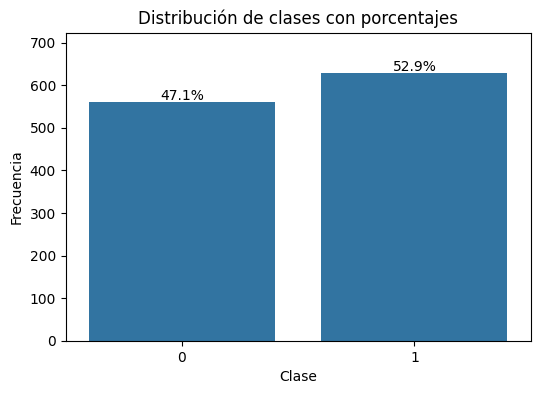

In [53]:
#
# Calcular frecuencia absoluta y relativa
conteo_obj = hd['target'].value_counts().sort_index()
relativo = hd['target'].value_counts(normalize=True).sort_index() * 100

# Crear figura y ejes
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=conteo_obj.index, y=conteo_obj.values)

# Agregar etiquetas de porcentaje sobre las barras
for i, val in enumerate(relativo.values):
    ax.text(i, conteo_obj.values[i] + 5, f'{val:.1f}%', ha='center')

# Estética del gráfico
plt.title("Distribución de clases con porcentajes")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.ylim(top=max(conteo_obj.values)*1.15)
plt.show()

Si bien etiqueta asociada a personas con mayor chance de desarrollar problemas cardíacos es más frecuente, ambas etiquetas difieren por menos de un 6 %, por lo que no se puede decir que este marco de datos esté desbalanceado. Así, se trabajará con estos mismos datos.

## <span style = 'color: cyan'>***2.2.***</span> Preprocesamiento de los datos

A continución, se definirá una tubería o *pipeline* con la cual se puede abordar el preprocesamiento de los datos. Para la conversión de los tipos de datos, se tomarán a las variables nominales como categóricas.

In [54]:
#
# Matriz de diseño y variable objetivo
X_inic = hd.drop('target', axis=1)
y_inic = hd['target']

X_inic.head()

   age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   40    1                2           140          289                    0   
1   49    0                3           160          180                    0   
2   37    1                2           130          283                    0   
3   48    0                4           138          214                    0   
4   54    1                3           150          195                    0   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  
0            0             172                0      0.0         1  
1            0             156                0      1.0         2  
2            1              98                0      0.0         1  
3            0             108                1      1.5         2  
4            0             122                0      0.0         1  

In [55]:
#
# Cambio de tipología de datos para variables categóricas
cat_feats = ['sex', 'chest pain type', 'fasting blood sugar',
             'resting ecg', 'exercise angina', 'ST slope',]
X_inic[cat_feats] = X_inic[cat_feats].astype('category')

X_inic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  1190 non-null   int64   
 1   sex                  1190 non-null   category
 2   chest pain type      1190 non-null   category
 3   resting bp s         1190 non-null   int64   
 4   cholesterol          1190 non-null   int64   
 5   fasting blood sugar  1190 non-null   category
 6   resting ecg          1190 non-null   category
 7   max heart rate       1190 non-null   int64   
 8   exercise angina      1190 non-null   category
 9   oldpeak              1190 non-null   float64 
 10  ST slope             1190 non-null   category
dtypes: category(6), float64(1), int64(4)
memory usage: 54.5 KB


In [56]:
#
# Selección de variables continuas y categóricas
cont_feats = X_inic.select_dtypes(include=[np.number]).columns.tolist()
cat_feats = X_inic.select_dtypes(include=['category']).columns.tolist()

print(
    'Variables continuas:',
    cont_feats,
    '\nVariables categóricas:',
    cat_feats,
    sep = '\n'
)

Variables continuas:
['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']

Variables categóricas:
['sex', 'chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope']


In [57]:
#
# Transformaciones para las variables continuas
num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ])

# Transformaciones para las variables categóricas
cat_pipe = Pipeline(steps=[
    ('onehot', OneHotEncoder(
        handle_unknown='ignore',
        drop='first')),
    ])

In [58]:
#
# Preprocesamiento
preprocesador = ColumnTransformer(
    transformers=[
        ('num', num_pipe, cont_feats),
        ('cat', cat_pipe, cat_feats)
    ],
    remainder='drop',
)

preprocesador

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [59]:
#
# Aplicación
X = preprocesador.fit_transform(X_inic)

# Conversión 
X_df = pd.DataFrame(X, columns=preprocesador.get_feature_names_out())
X_df.head()

   num__age  num__resting bp s  num__cholesterol  num__max heart rate  \
0 -1.466728           0.427328          0.775674             1.265039   
1 -0.504600           1.516587         -0.299512             0.637758   
2 -1.787437          -0.117301          0.716489            -1.636136   
3 -0.611503           0.318402          0.035867            -1.244085   
4  0.029915           0.971958         -0.151550            -0.695214   

   num__oldpeak  cat__sex_1  cat__chest pain type_2  cat__chest pain type_3  \
0     -0.849792         1.0                     1.0                     0.0   
1      0.071119         0.0                     0.0                     1.0   
2     -0.849792         1.0                     1.0                     0.0   
3      0.531575         0.0                     0.0                     0.0   
4     -0.849792         1.0                     0.0                     1.0   

   cat__chest pain type_4  cat__fasting blood sugar_1  cat__resting ecg_1  \
0        

Con esto listo, se puede proceder con el entrenamiento de los modelos.

In [60]:
#
# Obtención de los conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y_inic, test_size=0.25, random_state=42
)

## <span style = 'color: cyan'>***2.3.***</span> Clasificador de ***Bayes ingenuo***.

En este caso, se optimizará el parámetro de **suavizamiento**: `var_smoothing`. 

In [61]:
from sklearn.naive_bayes import GaussianNB

In [62]:
#
# Grilla de hiperparámetros
param_grid_nb = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

# Optimizador
grilla_nb = GridSearchCV(
    GaussianNB(),
    param_grid=param_grid_nb,
    scoring='accuracy',
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Ajuste del modelo
grilla_nb.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,estimator,GaussianNB()
,param_grid,{'var_smoothing': array([1.0000...00000000e-09])}
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,priors,None


In [63]:
#
# Extracción de los resultados de la optimización
result_nb = pd.DataFrame(grilla_nb.cv_results_)

# Extracción de parámetros y las exactitudes
var_smoothing_nb = result_nb['param_var_smoothing'].values
mean_test_score_nb = result_nb['mean_test_score'].values

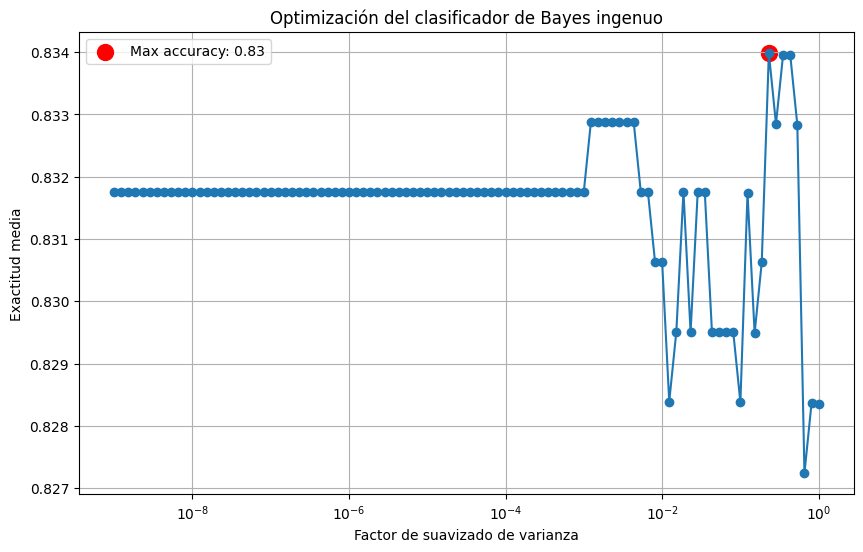

Mejor parámetro de suavizado de varianza: 0.23
Mejor exactitud: 0.83


In [64]:
#
# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(var_smoothing_nb, mean_test_score_nb, marker='o')
plt.xscale('log')
plt.xlabel('Factor de suavizado de varianza')
plt.ylabel('Exactitud media')
plt.title('Optimización del clasificador de Bayes ingenuo')

plt.scatter(
    var_smoothing_nb[np.argmax(mean_test_score_nb)],
    mean_test_score_nb.max(),
    color='red',
    s=120,              # tamaño más grande que los puntos normales
    edgecolors='red',
    linewidths=1.5,
    label=f'Max accuracy: {mean_test_score_nb.max():.2f}'
)

plt.legend()
plt.grid()
plt.show()

#
# Impresión de resultados
print(f"Mejor parámetro de suavizado de varianza: {grilla_nb.best_params_['var_smoothing']:.2f}")
print(f"Mejor exactitud: {grilla_nb.best_score_:.2f}")

In [65]:
#
# Mejor modelo
mejor_nb = grilla_nb.best_estimator_

In [66]:
def plot_confusion_and_roc(model, X_train, y_train, X_test, y_test, modelo=None, class_labels=None):
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Matriz de confusión
    cm_train = confusion_matrix(y_train, y_pred_train, labels=class_labels)
    cm_test = confusion_matrix(y_test, y_pred, labels=class_labels)

    # Curva ROC 
    fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_proba)
    auc_train = roc_auc_score(y_train, y_proba_train)
    auc_test = roc_auc_score(y_test, y_proba)

    acc_test = accuracy_score(y_test, y_pred)
    kappa_test = cohen_kappa_score(y_test, y_pred)

    acc_train = accuracy_score(y_train, y_pred_train)
    kappa_train = cohen_kappa_score(y_train, y_pred_train)

    # Figura con subplots 
    fig, axes = plt.subplots(2, 2, figsize=(6, 5))

    # Matriz de confusión - entrenamiento
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Matriz de confusión: entrenamiento', fontsize=10)
    axes[0, 0].set_xlabel('Predicción')
    axes[0, 0].set_ylabel('Real')

    # Matriz de confusión - validación
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
    axes[0, 1].set_title('Matriz de confusión: validación', fontsize=10)
    axes[0, 1].set_xlabel('Predicción')
    axes[0, 1].set_ylabel('Real')

    # Curva ROC - entrenamiento
    axes[1, 0].plot(fpr_train, tpr_train, color='darkorange',
                    label=f'AUC = {auc_train:.2f}\nExact: {acc_train:.2f}\nKappa = {kappa_train:.2f}')
    axes[1, 0].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('FPR')
    axes[1, 0].set_ylabel('TPR')
    axes[1, 0].set_title('Curva ROC: entrenamiento', fontsize=10)
    axes[1, 0].legend(loc='lower right', fontsize=7)

    # Curva ROC - validación
    axes[1, 1].plot(fpr_test, tpr_test, color='darkorange', 
                    label=f'AUC = {auc_test:.2f}\nExact = {acc_test:.2f}\nKappa = {kappa_test:.2f}')
    axes[1, 1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[1, 1].set_xlim([0.0, 1.0])
    axes[1, 1].set_ylim([0.0, 1.05])
    axes[1, 1].set_xlabel('FPR')
    axes[1, 1].set_ylabel('TPR')
    axes[1, 1].set_title('Curva ROC: validación', fontsize=10)
    axes[1, 1].legend(loc='lower right', fontsize=7)

    fig.suptitle(f"Desempeño del modelo: {modelo}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    # Métricas de evaluación
    print("MÉTRICAS DE EVALUACIÓN - ENTRENAMIENTO")
    print(f"F1 Score: {f1_score(y_train, y_pred_train):.2f}")
    print(f"Precisión: {precision_score(y_train, y_pred_train):.2f}")
    print(f"Recall: {recall_score(y_train, y_pred_train):.2f}")
    print("\nReporte de clasificación:")
    print(classification_report(y_train, y_pred_train, target_names=class_labels))

    print("\nMÉTRICAS DE EVALUACIÓN - VALIDACIÓN")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"Precisión: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=class_labels))

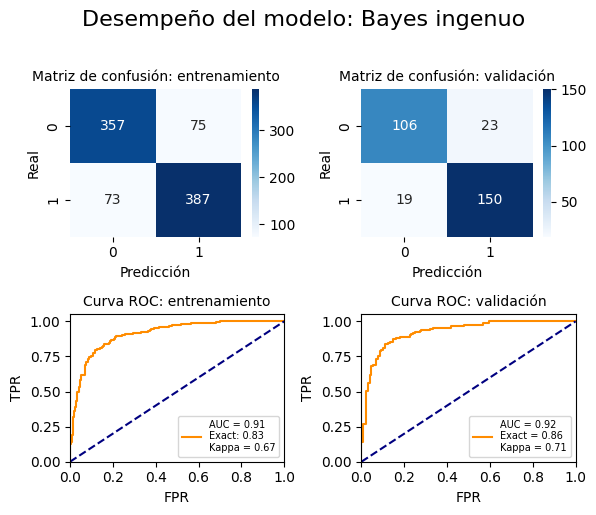

MÉTRICAS DE EVALUACIÓN - ENTRENAMIENTO
F1 Score: 0.84
Precisión: 0.84
Recall: 0.84

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       432
           1       0.84      0.84      0.84       460

    accuracy                           0.83       892
   macro avg       0.83      0.83      0.83       892
weighted avg       0.83      0.83      0.83       892


MÉTRICAS DE EVALUACIÓN - VALIDACIÓN
F1 Score: 0.88
Precisión: 0.87
Recall: 0.89

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       129
           1       0.87      0.89      0.88       169

    accuracy                           0.86       298
   macro avg       0.86      0.85      0.86       298
weighted avg       0.86      0.86      0.86       298



In [67]:
plot_confusion_and_roc(mejor_nb, X_train, y_train, X_test, y_test, modelo='Bayes ingenuo',)

En general, se puede ver que el modelo de Bayes ingenuo tiene un desempeño adecuado, en la medida que la mayoría de etiquetas para ambos casos están siendo correctamente clasificados. Lo que es posible anticipar de esta matriz de confusión es que hay un mayor error en la predicción cuando no hay riesgo de problemas cardíacos, en la medida que hay una mayor cantidad de equivocaciones a pesar de que esta etiqueta tiene ligeramente menos instancias. Esto se puede validar con el reporte de clasificación, donde se que para las distintas métricas, estas son peores para tal etiqueta.

Es importante notar que este modelo cuenta con buena capacidad de generalización, en la medida que las métricas no se degradan de forma especial en el conjunto de entrenamiento respecto al conjunto de validación.

## <span style = 'color: cyan'>***2.4.***</span> Clasificador de ***$k$ vecinos más cercanos***.

En este caso, se optimizarán los hiperparámetros de la cantidad de vecinos, los pesos, y el parámetro de Minkowski para tomar distancia Manhattan o euclidiana.

In [68]:
from sklearn.neighbors import KNeighborsClassifier

In [69]:
#
# Grilla de hiperparámetros
param_grid_knn = {
    'n_neighbors': np.arange(1, 40, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Optimizador
grilla_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid_knn,
    scoring='accuracy',
    cv=10,
    n_jobs=-1,
    verbose=1,
)

# Ajuste del modelo
grilla_knn.fit(X_train, y_train)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


,estimator,KNeighborsClassifier()
,param_grid,"{'metric': ['euclidean', 'manhattan'], 'n_neighbors': array([ 1, 3... 35, 37, 39]), 'weights': ['uniform', 'distance']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,np.int64(17)


In [70]:
#
# Extracción de los resultados de la optimización
result_knn = pd.DataFrame(grilla_knn.cv_results_)
results_knn = result_knn.sort_values(by='mean_test_score', ascending=False)

# Extracción de parámetros y las exactitudes
n_neighbors_knn = result_knn['param_n_neighbors'].astype(np.int64).values
mean_test_score_knn = result_knn['mean_test_score'].values  
metricas_knn = result_knn['param_metric'].unique()

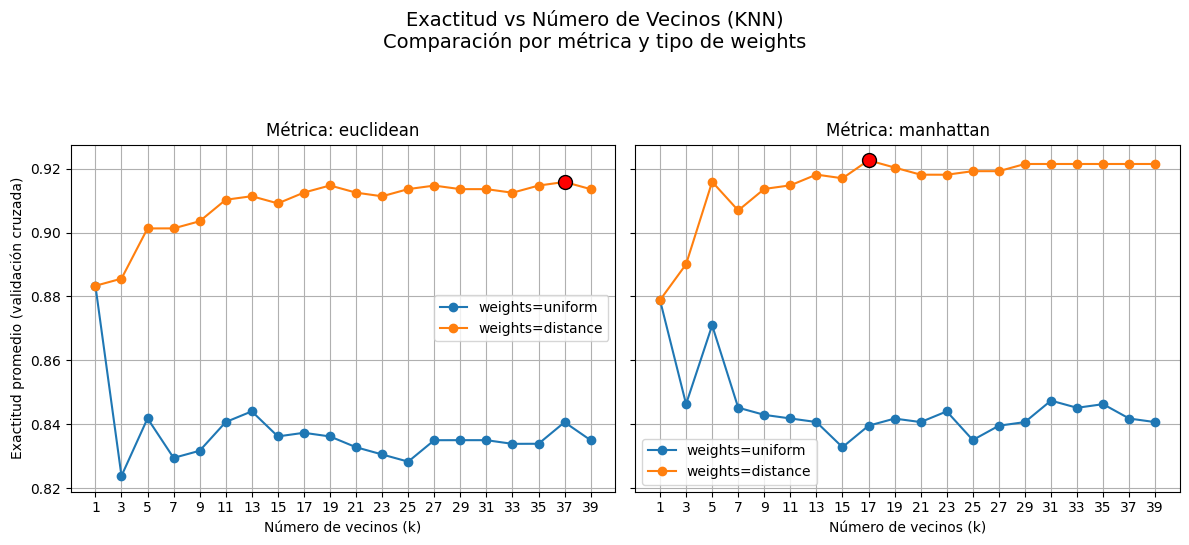

In [71]:
fig, axes = plt.subplots(1, len(metricas_knn), figsize=(12, 5), sharey=True)

for i, metrica in enumerate(metricas_knn):
    ax = axes[i]
    df_metrica = result_knn[result_knn['param_metric'] == metrica]

    # Inicializar listas para la búsqueda del mejor punto global en esta métrica
    mejores_k = []
    mejores_acc = []
    mejores_idx = []

    for peso in df_metrica['param_weights'].unique():
        df_sub = df_metrica[df_metrica['param_weights'] == peso]
        df_sub = df_sub.sort_values(by='param_n_neighbors')

        k_vals = df_sub['param_n_neighbors'].astype(int)
        acc_vals = df_sub['mean_test_score']

        ax.plot(k_vals, acc_vals, marker='o', label=f'weights={peso}')

        # Guardar los mejores candidatos
        idx_max = acc_vals.idxmax()
        mejores_k.append(k_vals.loc[idx_max])
        mejores_acc.append(acc_vals.loc[idx_max])
        mejores_idx.append(idx_max)

    # Elegir el mejor entre todos los pesos
    idx_best_in_metrica = np.argmax(mejores_acc)
    best_k = mejores_k[idx_best_in_metrica]
    best_acc = mejores_acc[idx_best_in_metrica]

    # Dibujar el círculo solo en el mejor global de esa métrica
    ax.scatter(best_k, best_acc, color='red', s=100, edgecolors='black', zorder=5)

    ax.set_title(f"Métrica: {metrica}")
    ax.set_xlabel("Número de vecinos (k)")
    if i == 0:
        ax.set_ylabel("Exactitud promedio (validación cruzada)")
    ax.grid(True)
    ax.legend()

    ax.set_xticks(sorted(df_metrica['param_n_neighbors'].unique()))

# Título general
fig.suptitle("Exactitud vs Número de Vecinos (KNN)\nComparación por métrica y tipo de weights", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()

Como se puede observar, en el caso en el que se le otorga una mayor relevancia a las instancias *más cercanas* (y no de manera igualitaria), se alcanza una mejor exactitud. Además, cuando la métrica que se usa es la de Manhattan, se logra una mejor exactitud. En general, los mejor parámetros son:

In [72]:
# Impresión de resultados
print(f"Mejor parámetro de suavizado de varianza: {grilla_knn.best_params_}")
print(f"Mejor exactitud: {grilla_knn.best_score_:.2f}")

Mejor parámetro de suavizado de varianza: {'metric': 'manhattan', 'n_neighbors': np.int64(17), 'weights': 'distance'}
Mejor exactitud: 0.92


In [73]:
#
# Mejor modelo
mejor_knn = grilla_knn.best_estimator_

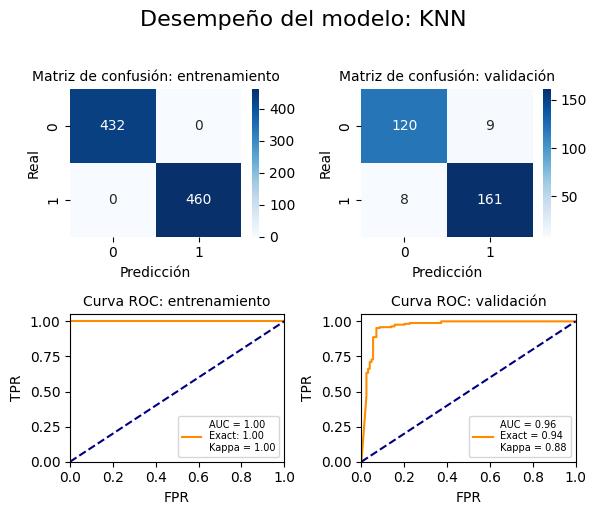

MÉTRICAS DE EVALUACIÓN - ENTRENAMIENTO
F1 Score: 1.00
Precisión: 1.00
Recall: 1.00

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       432
           1       1.00      1.00      1.00       460

    accuracy                           1.00       892
   macro avg       1.00      1.00      1.00       892
weighted avg       1.00      1.00      1.00       892


MÉTRICAS DE EVALUACIÓN - VALIDACIÓN
F1 Score: 0.95
Precisión: 0.95
Recall: 0.95

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       129
           1       0.95      0.95      0.95       169

    accuracy                           0.94       298
   macro avg       0.94      0.94      0.94       298
weighted avg       0.94      0.94      0.94       298



In [74]:
plot_confusion_and_roc(mejor_knn, X_train, y_train, X_test, y_test, modelo='KNN',)

El modelo de *K vecinos más cercanos* tiene un desempeño superior al de K vecinos más cercanos, refléjandose en un aumento en todas las métricas y un mayor AUC. Además, si bien para los pacientes que en realidad no tienen riesgo de desarrollar enfermedades cardíacas aún se cumple que sus métricas son inferiores que para la otra clase, sí se evidencia un cierre en la brecha, pasadno por ejemplo de una diferencia de 7 % en el *recall*, a una brecha de solo 2 % en este caso.

Un aspecto relevante de este modelo es que, para el caso del conjunto de entrenamiento, hay una predicción perfecta de las etiquetas. Esto hace que exista una brecha con el conjunto de validación por posible memorización de patrones de los datos con los que se ajustó el modelo, no obstante, esto no debería ser especialmente delicado teniendo en cuenta que el modelo fue entrenado usando validación cruzada con diez particiones.

## <span style = 'color: cyan'>***2.5.***</span> Clasificador de ***máquinas de soporte vectorial***.

Se van a definir varias grillas en función del tipo de kernel a proponer.

In [75]:
from sklearn.svm import SVC

In [76]:
#
# Grilla de hiperparámetros
param_grid_svc = [
    {
        'kernel': ['linear'],
        'C': [0.01, 0.1, 1, 10, 100]
    },
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']
    },
    {
        'kernel': ['poly'],
        'C': [0.1, 1, 10],
        'degree': [2, 3, 4],
        'gamma': [0.01, 0.1, 'scale'],
        'coef0': [0, 0.5, 1]
    },
    {
        'kernel': ['sigmoid'],
        'C': [0.1, 1, 10],
        'gamma': [0.01, 0.1, 'scale'],
        'coef0': [0, 0.5, 1]
    }
]

# Optimizador
grilla_svc = GridSearchCV(
    SVC(probability=True, random_state=202506),
    param_grid=param_grid_svc,
    scoring='accuracy',
    cv=10,
    n_jobs=-1,
    verbose=1,
)

# Ajuste del modelo
grilla_svc.fit(X_train, y_train)

Fitting 10 folds for each of 137 candidates, totalling 1370 fits


,estimator,SVC(probabili..._state=202506)
,param_grid,"[{'C': [0.01, 0.1, ...], 'kernel': ['linear']}, {'C': [0.1, 1, ...], 'gamma': [0.001, 0.01, ...], 'kernel': ['rbf']}, ...]"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [77]:
#
# Mejor modelo
mejor_svc = grilla_svc.best_estimator_
mejor_svc_params = grilla_svc.best_params_

# Mejor modelo
mejor_svc_final = SVC(**mejor_svc_params, probability=True, random_state=202506)

# Reentrenar
mejor_svc_final.fit(X_train, y_train)

,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


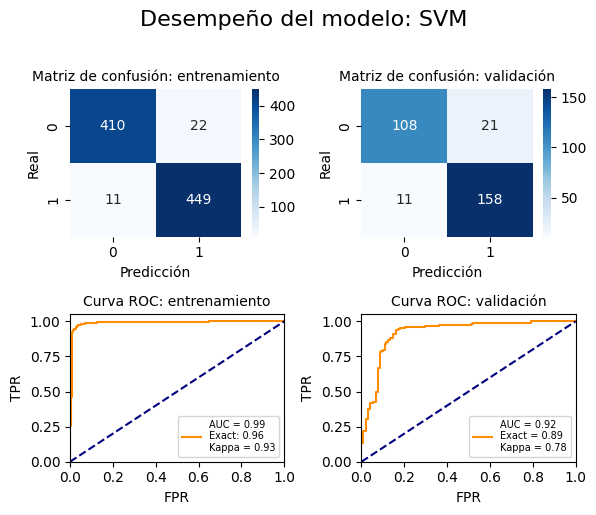

MÉTRICAS DE EVALUACIÓN - ENTRENAMIENTO
F1 Score: 0.96
Precisión: 0.95
Recall: 0.98

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       432
           1       0.95      0.98      0.96       460

    accuracy                           0.96       892
   macro avg       0.96      0.96      0.96       892
weighted avg       0.96      0.96      0.96       892


MÉTRICAS DE EVALUACIÓN - VALIDACIÓN
F1 Score: 0.91
Precisión: 0.88
Recall: 0.93

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       129
           1       0.88      0.93      0.91       169

    accuracy                           0.89       298
   macro avg       0.90      0.89      0.89       298
weighted avg       0.89      0.89      0.89       298



In [78]:
plot_confusion_and_roc(mejor_svc_final, X_train, y_train, X_test, y_test, modelo='SVM',)

Nótese que el mejor kernel es el `rbf`. Este modelo presenta un mejor desempeño que el modelo de Bayes ingenuo; sin embargo, no logra superar al de $k$ vecinos más cercano. Además, amplía la brecha en el desempeño individual de las clases.

Por otro parte, si bien este modelo no tiene resultados perfectos, sí se tiene una brecha más amplia si se compara con el modelo de Bayes ingenuo; sin embargo, es el mejor candidato hasta el momento por sus resultados en el conjunto de validación.

## <span style = 'color: cyan'>***2.6.***</span> Clasificador de ***redes neuronales***.

In [79]:
from sklearn.neural_network import MLPClassifier

In [80]:
#
# Grilla de hiperparámetros
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 50, 25, 12)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 300, 400],
    'random_state': [202506]
}

# Optimizador
grilla_mlp = GridSearchCV(
    MLPClassifier(),
    param_grid=param_grid_mlp,
    scoring='accuracy',
    cv=10,
    n_jobs=-1,
    verbose=1,
)

# Ajuste del modelo
grilla_mlp.fit(X_train, y_train)

Fitting 10 folds for each of 1080 candidates, totalling 10800 fits


,estimator,MLPClassifier()
,param_grid,"{'activation': ['logistic', 'tanh', ...], 'alpha': [0.0001, 0.001, ...], 'hidden_layer_sizes': [(50,), (100,), ...], 'learning_rate': ['constant', 'invscaling', ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,hidden_layer_sizes,"(100, ...)"


In [81]:
#
# Mejor modelo
mejor_mlp_clasif = grilla_mlp.best_estimator_
mejor_mlp_clasif_params = grilla_mlp.best_params_

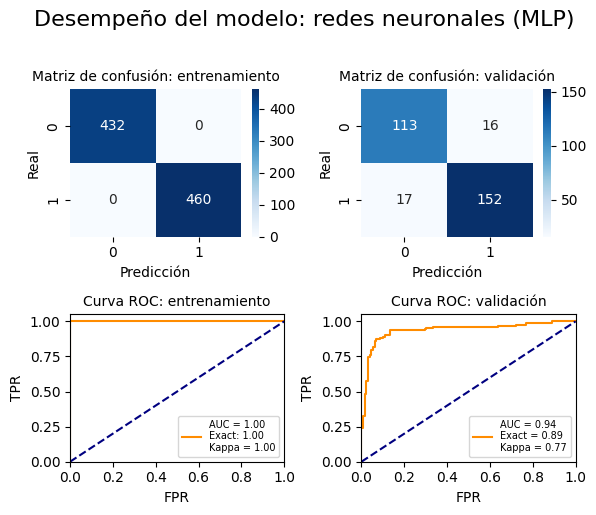

MÉTRICAS DE EVALUACIÓN - ENTRENAMIENTO
F1 Score: 1.00
Precisión: 1.00
Recall: 1.00

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       432
           1       1.00      1.00      1.00       460

    accuracy                           1.00       892
   macro avg       1.00      1.00      1.00       892
weighted avg       1.00      1.00      1.00       892


MÉTRICAS DE EVALUACIÓN - VALIDACIÓN
F1 Score: 0.90
Precisión: 0.90
Recall: 0.90

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       129
           1       0.90      0.90      0.90       169

    accuracy                           0.89       298
   macro avg       0.89      0.89      0.89       298
weighted avg       0.89      0.89      0.89       298



In [82]:
plot_confusion_and_roc(mejor_mlp_clasif, X_train, y_train, X_test, y_test, modelo='redes neuronales (MLP)',)

Las redes neuronales tienen, para el conjunto de validación, un desempeño bastante semejante al de los modelos anteriores. No obstante, se tiene que para el conjunto de entrenamiento se obtiene un resultado perfecto, semejante a como sucedió con KNN.

## <span style = 'color: cyan'>***2.7.***</span> Clasificador de ***ensamble:*** bosques aleatorios

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
#
# Grilla de hiperparámetros
param_grid_clasif_rf = {
    'n_estimators': [100, 200, 300, ],
    'max_depth': [None, 10, 20, 30, ],
    'min_samples_split': [2, 5, 10, ],
    'min_samples_leaf': [1, 2, 4, ],
    'max_features': ['sqrt', 'log2', ],
    'random_state': [202506, ],
    'criterion': ['gini', 'entropy', ],
}

# Optimizador
grilla_clasif_rf = GridSearchCV(
    RandomForestClassifier(),
    param_grid=param_grid_clasif_rf,
    scoring='accuracy',
    cv=10,
    n_jobs=-1,
    verbose=1,
) 

# Ajuste del modelo
grilla_clasif_rf.fit(X_train, y_train)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


,estimator,RandomForestClassifier()
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [85]:
#
# Mejor modelo
mejor_rf_clasif = grilla_clasif_rf.best_estimator_
mejor_rf_clasif

,n_estimators,300
,criterion,'entropy'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


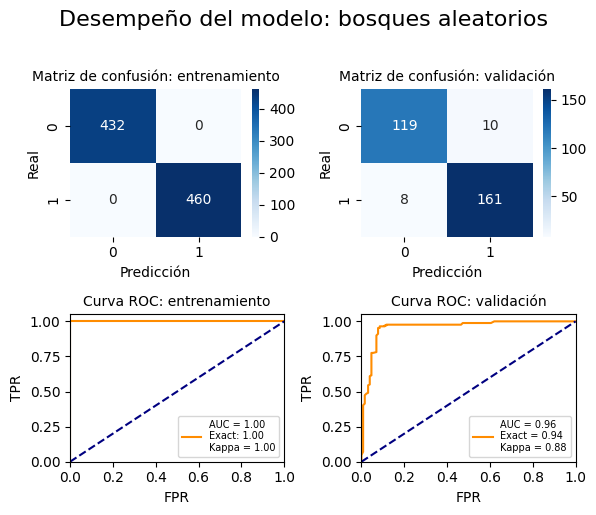

MÉTRICAS DE EVALUACIÓN - ENTRENAMIENTO
F1 Score: 1.00
Precisión: 1.00
Recall: 1.00

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       432
           1       1.00      1.00      1.00       460

    accuracy                           1.00       892
   macro avg       1.00      1.00      1.00       892
weighted avg       1.00      1.00      1.00       892


MÉTRICAS DE EVALUACIÓN - VALIDACIÓN
F1 Score: 0.95
Precisión: 0.94
Recall: 0.95

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       129
           1       0.94      0.95      0.95       169

    accuracy                           0.94       298
   macro avg       0.94      0.94      0.94       298
weighted avg       0.94      0.94      0.94       298



In [86]:
plot_confusion_and_roc(mejor_rf_clasif, X_train, y_train, X_test, y_test, modelo='bosques aleatorios',)

En general, el modelo de bosques aleatorios tiene un desempeño muy bueno, similar al de los $k$ vecinos más cercanos; no obstante, al entrar al detalle de cada las dos clases por separado, se ve que la brecha es ligeralmente superior en este caso, pues si se toma el *recall* por ejemplo, pasa de un 2 % con KNN a un 3 % con bosques aleatorios. No obstante, también obtiene resultados perfectos en el conjunto de prueba.

## <span style = 'color: cyan'>***2.8.***</span> Comentarios finales

En el siguiente cuadro se ven los resultados obtenidos con los diferentes modelos:

| Modelo                 | AUC entrenam. | Exactitud entrenam. | AUC valid. | Exactitud valid. |
|------------------------|---------------|---------------------|------------|------------------|
| Bayes ingenuo          | 0.91          | 0.83                | 0.92       | 0.86             |
| KNN                    | **1.00**      | **1.00**            | **0.96**   | **0.94**         |
| SVM                    | 0.99          | 0.96                | 0.92       | 0.89             |
| Redes neuronales (MLP) | 1.00          | 1.00                | 0.94       | 0.89             |
| **Bosque aleatorio**   | **1.00**      | **1.00**            | **0.96**   | **0.94**         |

El modelo de Bayes ingenuo es que el peores métricas obtiene entre todos los modelos, si bien no son malas y pudiera ser un buen candidato si no se hubiera apelado a demás modelos. A continuación, están las máquinas de soporte vectorial (SVM), que tienen un resultado casi perfecto en entrenamiento, y no tienen una degradación especialmente mala en el conjunto de prueba. Por su parte, las redes neuronales, cuentan con un resultado perfecto en entrenamiento, y en validación son ligeramente mejores que las SVM de acuerdo con el AUC. Por último, se tiene que los bosques aleatorios y el modelo de KNN obtiene iguales resultados: desempeño perfecto en entrenamiento y casi perfecto en validación. Respecto a este desempeño, podría abrirse la puerta a un posible problema de generalización; no obstante, es importante tener en cuenta que todos los modelos fueron entrenados usando optimización de hiperparámetros vía búsqueda en grilla (*grid search*) con divisiones en diez conjuntos de datos, lo que disipa las dudas sobre posibles problemas de memorización.

<span style = 'color: red'>***Conclusión.***</span> Con todo esto, el mejor modelo es el de **bosques aleatorios**, ya que si bien tiene las mismas métricas que el modelo de KNN, este el algoritmo de ensamble es menos susceptible a valores atípicos, por lo que puede desempeñarse mejor con nuevos datos desconocidos.